In [1]:
import os

In [2]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'

In [5]:
proj_link = 'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'
os.chdir(proj_link)

In [6]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir : Path
    test_data_path: Path
    model_path: Path
    preprocessor_path : Path
    all_params : dict
    metric_file_name: Path
    target_column: str
    mlflow_uri: str
    xgb_encoder: Path
    sm_model: Path
    rf_model: Path
    rf_processor: Path
    xgb_processor: Path
    xgb_model: Path
    xgb_final_model: Path
    xgb_pipeline_eval: Path
    
    
    
    






In [7]:
from clientClassifier.constants import *    
from clientClassifier.utils.common import read_yaml, create_directories, save_json

In [8]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config['artifacts_root']])
        
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config['model_evaluation']
        params = self.params['xgb_classifier_best']
        schema = self.schema['TARGET_COLUMN']
        
        create_directories([config['root_dir']])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=Path(config['root_dir']),
            test_data_path=Path(config['test_data_path']),
            model_path=Path(config['model_path']),
            rf_model = Path(config['rf_model']),
            rf_processor  = Path(config['rf_processor']),
            preprocessor_path = Path(config['preprocessor_path']),
            xgb_encoder= Path(config['xgb_encoder']),
            xgb_model= Path(config['xgb_model']),   
            sm_model = Path(config['sm_model']),
            xgb_processor = Path(config['xgb_processor']),  
            all_params=params,
            metric_file_name=Path(config['metric_file_name']),
            xgb_final_model=Path(config['xgb_final_model']),
            target_column=schema.name,
            xgb_pipeline_eval=Path(config['xgb_pipeline_eval']),
            mlflow_uri="https://dagshub.com/richardmukechiwa/client-subscription-prediction.mlflow"
        )
        
        return model_evaluation_config
                
          

In [9]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
import joblib
import mlflow 
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import shap
from clientClassifier import logger
import numpy as np
import optuna
import base64
from io import BytesIO







In [10]:

class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred, average='weighted')
        recall = recall_score(actual, pred, average='weighted')
        f1 = f1_score(actual, pred, average='weighted')
        return accuracy, precision, recall, f1

    def log_confusion_matrix(self, actual, predicted, class_names):
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
        plt.savefig(temp_img_path)
        plt.close()

        mlflow.log_artifact(temp_img_path, artifact_path="confusion_matrix")

    def log_classification_report(self, actual, predicted, class_names):
        report = classification_report(actual, predicted, target_names=class_names)
        temp_txt_path = tempfile.NamedTemporaryFile(suffix=".txt", delete=False).name
        with open(temp_txt_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(temp_txt_path, artifact_path="xgb_classification_report")

    def log_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        
        model = joblib.load(self.config.xgb_pipeline_eval)
        encoder = joblib.load(self.config.xgb_encoder)
    

        test_x = test_data.drop(self.config.target_column, axis=1)
        test_y = test_data[self.config.target_column]
        
        #label encoding the target variable
        test_y = encoder.transform(test_y)
        

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        mlflow.set_experiment("classification_with_xgbclassifier_artifacts_stored")
        

        if mlflow.active_run():
            mlflow.end_run()

        with mlflow.start_run():
            #processing = model.transform(test_x)
           
            predicted_qualities = model.predict(test_x)
            
            accuracy, precision, recall, f1 = self.eval_metrics(test_y, predicted_qualities)

            model_name = "xgb_classifier" 

            scores = {
                "model_name": model_name,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }

            save_json(path=Path(self.config.metric_file_name), data=scores)

            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)

            class_names =encoder.classes_
            self.log_confusion_matrix(test_y, predicted_qualities, class_names)
            self.log_classification_report(test_y, predicted_qualities, class_names)

            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(model, "model", registered_model_name="XGB ClassificationModel")
            else:
                mlflow.sklearn.log_model(model, "model")




    def feature_importance(self):
        
        test_data = pd.read_csv(self.config.test_data_path)
        
        test_x = test_data.drop(self.config.target_column, axis=1)
        
        # change the month column to string
        test_x['month'] = test_x['month'].astype('str')
        
        
        pipeline = joblib.load(self.config.xgb_pipeline_eval)
        
         # Extract preprocessor and model from pipeline
        preprocessor = pipeline.named_steps['preprocessor']
        model = pipeline.named_steps['classifier']

        # Transform test data using preprocessor
        X_processed = preprocessor.transform(test_x)

        # Get feature names after preprocessing
        try:
            feature_names = preprocessor.get_feature_names_out()
        except AttributeError:
            num_features = preprocessor.transformers_[0][2]
            cat_encoder = preprocessor.transformers_[1][1]
            cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
            feature_names = np.concatenate([num_features, cat_features])

        # Convert processed features to DataFrame
        X_df = pd.DataFrame(
            X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed,
            columns=feature_names
        )
        
        print(X_df.columns)
        
         
        
        # Create SHAP explainer and compute SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_df)

        # Generate SHAP plot
        shap.summary_plot(shap_values, X_df, show=False)
        #buf = BytesIO()
        #plt.savefig(buf, format="png", bbox_inches='tight')
        #plt.close()
        #buf.seek(0)

        # Encode image to base64
        #img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
        #return img_base64
        
        # For regression or binary classification
        shap_df = pd.DataFrame(shap_values, columns=X_df.columns)
        shap_abs_mean = shap_df.abs().mean().sort_values(ascending=False)


        # 6. Select top N important features
        top_n = 10  # You can change this to any number or use a threshold
        top_features = shap_abs_mean.head(top_n).index.tolist()

        print("Top Important Features:")
        print(top_features)
        
        
        
        # SHAP report
        logger.info("Key SHAP Plot Insights.")
        
        print()
        print('<' * 70)
        print()
        
            
        logger.info("cat__poutcome_success: Strongest positive driver — previous campaign success greatly increases subscription likelihood.")
        
        print()
        print('<' * 70)
        print()

        logger.info("cat__month_10: October contacts have high success rates; timing plays a crucial role.")
        
        print()
        print('<' * 70)
        print()

        logger.info("num__balance: Higher customer balance correlates with greater likelihood to subscribe.")
        
        print()
        print('<' * 70)
        print()

        logger.info("num__age: Age has a moderate impact; both young and older clients influence model outcomes.")
        
        print()
        print('<' * 70)
        print()

        logger.info("num__day: Certain days of the month slightly improve subscription chances.")
        
        print()
        print('<' * 70)
        print()

        logger.info("cat__poutcome_failure: Prior failure in a campaign significantly reduces the chance of subscribing again.")
        
        print()
        print('<' * 70)
        print()

        logger.info("num__campaign: More contact attempts usually lower success probability (over-contacting).")
        
        print()
        print('<' * 70)
        print()

        logger.info("cat__job_blue-collar: Blue-collar workers are less likely to subscribe; messaging should be adjusted or resources reallocated.")
        
        print()
        print('<' * 70)
        print()

        logger.info("cat__education_primary: Clients with only primary education are less responsive.")
        print()
        print('<' * 70)
        print()
        logger.info("cat__month_3 & cat__month_11: March and November also show campaign success, consider seasonal targeting.")




       
       
    #Evaluation and mlflow  on selected features
    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred, average='weighted')
        recall = recall_score(actual, pred, average='weighted')
        f1 = f1_score(actual, pred, average='weighted')
        return accuracy, precision, recall, f1

    def log_confusion_matrix(self, actual, predicted, class_names):
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
        plt.savefig(temp_img_path)
        plt.close()

        mlflow.log_artifact(temp_img_path, artifact_path="confusion_matrix")

    def log_classification_report(self, actual, predicted, class_names):
        report = classification_report(actual, predicted, target_names=class_names)
        temp_txt_path = tempfile.NamedTemporaryFile(suffix=".txt", delete=False).name
        with open(temp_txt_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(temp_txt_path, artifact_path="xgb_classification_report")

    def log_selected_features_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        
        model = joblib.load(self.config.xgb_pipeline_eval)
        encoder = joblib.load(self.config.xgb_encoder)
    

        test_x = test_data.drop(self.config.target_column, axis=1)
        test_y = test_data[self.config.target_column]
        
        test_x['month'] = test_x['month'].astype('str')
        
        
        #introduce selected features
        
        important_features = ['age', 'month', 'day', 'balance', 'poutcome']
        
        test_x  = test_x[important_features]
        
        #label encoding the target variable
        test_y = encoder.transform(test_y)
        

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        mlflow.set_experiment("classification_with_xgbclassifier_on_selected_features")
        

        if mlflow.active_run():
            mlflow.end_run()

        with mlflow.start_run():
            #processing = model.transform(test_x)
           
            predicted_qualities = model.predict(test_x)
            
            
            accuracy, precision, recall, f1 = self.eval_metrics(test_y, predicted_qualities)
            
            # evaluate the model
            xgb_report = classification_report(test_y, predicted_qualities)
            xgb_cm = confusion_matrix(test_y, predicted_qualities)   
            xgb_accuracy = accuracy_score(test_y, predicted_qualities)   
            
            #create Confusion Matrix Display
            cm_display = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=encoder.classes_)
            cm_display.plot()
            plt.title("XGBClassifier Matrix")

            logger.info(f"XGBoost Classification Report:\n{xgb_report}")
            logger.info(f"XGBoost Confusion Matrix:\n{xgb_cm}") 
            logger.info(f"XGBoost Accuracy: {xgb_accuracy}")
            
            
           

            model_name = "xgb_classifier_best" 

            scores = {
                "model_name": model_name,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }

            save_json(path=Path(self.config.metric_file_name), data=scores)

            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)

            class_names =encoder.classes_
            self.log_confusion_matrix(test_y, predicted_qualities, class_names)
            self.log_classification_report(test_y, predicted_qualities, class_names)

            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(model, "model", registered_model_name="XGB ClassificationModel")
            else:
                mlflow.sklearn.log_model(model, "model")
                
   
            return xgb_report, xgb_cm, xgb_accuracy
        
        
            
          
        
                               

[2025-05-04 22:27:33,156: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-04 22:27:33,161: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-04 22:27:33,175: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-05-04 22:27:33,195: INFO: common: created directory at: artifacts]
[2025-05-04 22:27:33,197: INFO: common: created directory at: artifacts/model_evaluation]
Index(['num__age', 'num__day', 'num__balance', 'cat__month_1', 'cat__month_10',
       'cat__month_11', 'cat__month_12', 'cat__month_2', 'cat__month_3',
       'cat__month_4', 'cat__month_5', 'cat__month_6', 'cat__month_7',
       'cat__month_8', 'cat__month_9', 'cat__poutcome_failure',
       'cat__poutcome_other', 'cat__poutcome_success',
       'cat__poutcome_unknown'],
      dtype='object')
Top Important Features:
['cat__poutcome_success', 'cat__month_5', 'num__balance', 'cat__month_10', 'cat__month_3', 'num__age', 'num__day', 'cat__month_12', 'cat__month_2', 'cat__mo

2025/05/04 22:27:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


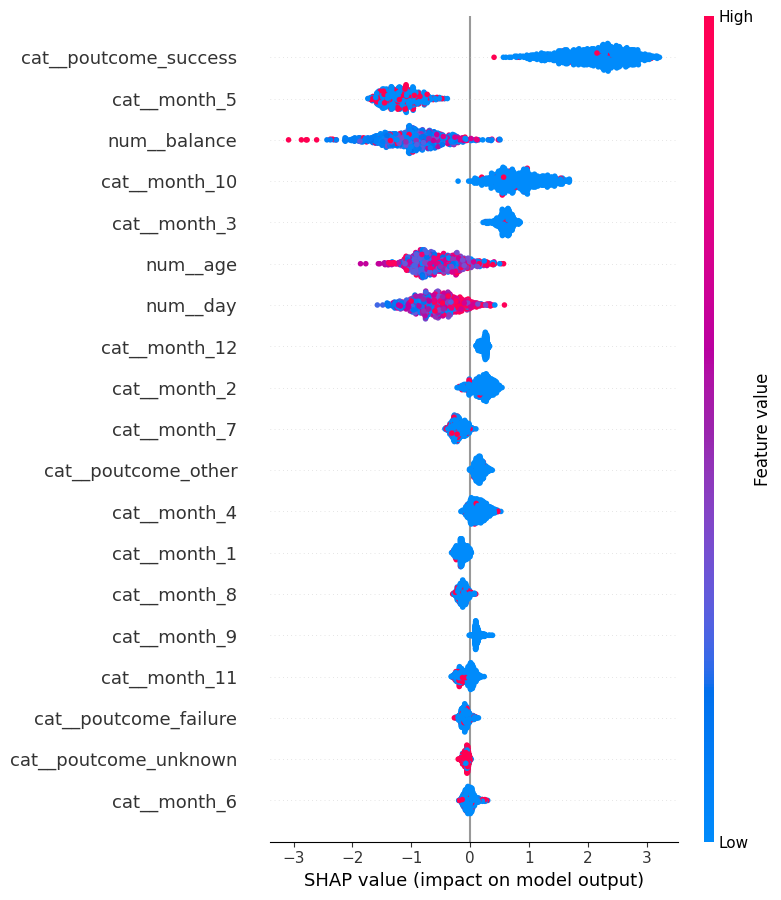

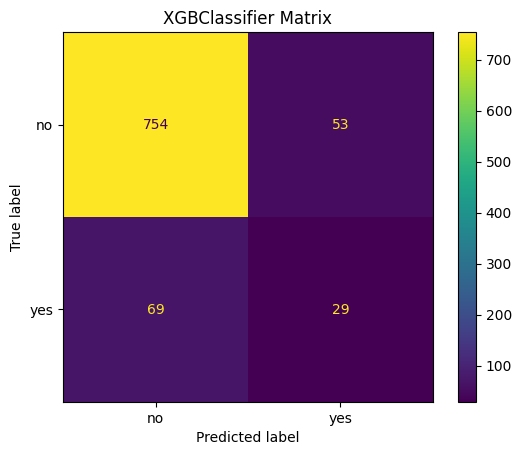

In [11]:



try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)  # Initialize model_evaluation
    model_evaluation.feature_importance()
    model_evaluation.log_selected_features_into_mlflow()
    
 
except Exception as e:
    raise e